# Structured RerF Demo: Circle Experiment
Similar to Figure 14 in [this paper](https://arxiv.org/pdf/1506.03410v4.pdf), we form a two-class classification problem in which each data point is a discretization of a circle into 100 points. In each class, two non-adjacent sequences of points take on the value one while the rest of the points take on the value zero. In class 0, both sequences are of length five while in class 1 the sequences are of length four and six. Sequences are distributed uniformly and wrap around from the end of the vector to the start if necessary.

We test the performance of S-Rerf and a set of other classification algorithms, training each on samples of sizes $n \in \{50,100,200,400,1000,2000\}$, each containing an equal number of data points from each class. The average 0-1 loss is evaluated for each algorithm for each training size using a single test set of size $m=10000$ with an equal number of data points in each class.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
def samp(n1,n2):
    ## Sample objects from each class
    n1,n2 = int(n1),int(n2)
    X1 = np.empty((n1,100))
    Y1 = np.full(n1,0)
    for i in range(n1):        
        cir = np.zeros(100)
        
        s1 = np.random.choice(range(0,100)) # Random Location
        l1 = [j%100 for j in range(s1,s1+5)] # Length 5 vector from s1
        
        exclude_idx = set([j%100 for j in range(s1-5,s1+6)])
        s2 = np.random.choice(list(set(range(0,100)).difference(exclude_idx)))
        l2 = [j%100 for j in set(range(s2,s2+5)).difference(set(l1))]
        
        cir[l1] = 1
        cir[l2] = 1
        
        X1[i] = cir
        
    X2 = np.empty((n2,100))
    Y2 = np.full(n2,1)
    for i in range(n2):        
        cir = np.zeros(100)
        
        s1 = np.random.choice(range(0,100)) # Random location   
        l1 = [j%100 for j in range(s1,s1+4)] # Length 4 vector from s1
        
        exclude_idx = set([j%100 for j in range(s1-6,s1+5)])
        s2 = np.random.choice(list(set(range(0,100)).difference(exclude_idx)))
        l2 = [j%100 for j in set(range(s2,s2+6)).difference(set(l1))]
        
        cir[l1] = 1
        cir[l2] = 1
        
        X2[i] = cir
        
    return((np.vstack([X1,X2]),np.hstack([Y1,Y2])))

In [25]:
## Generate train and test sets
np.random.seed(1234)
ns = np.array([10,50,100,200,400,1000,2000])
TRAIN_FRAC = 0.5
ns1 = [int(i*TRAIN_FRAC) for i in ns]
ns2 = ns1

X_train, Y_train = np.empty(shape=(0,100)), np.empty(shape=(0))
for n1,n2 in zip(np.append(ns1[0],np.diff(a=ns1)),
                 np.append(ns2[0],np.diff(a=ns2))):
    x, y = samp(n1,n2)
    shuffled_idx = list(range(len(y))); np.random.shuffle(shuffled_idx)
    X_train = np.vstack((X_train, x[shuffled_idx]))
    Y_train = np.hstack((Y_train, y[shuffled_idx]))
    

TEST_SIZE = 10000
X_test, Y_test = samp(TEST_SIZE, TEST_SIZE)

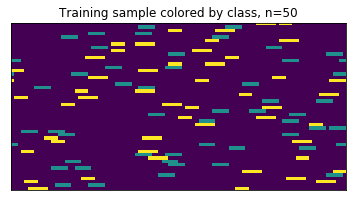

In [4]:
## Visualize the training data as an image
fig = plt.figure(figsize=(5,5),facecolor='white')
temp = X_train[:50].copy()
temp[np.where(Y_train[:50]==1)[0]] *= 2
plt.imshow(temp)
plt.title("Training sample colored by class, n=50",fontsize=12)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()

In [26]:
## Setup for run, define classifiers to train and test
names = {"Log. Reg": "#a6cee3", 
         "Lin. SVM":"#1f78b4", 
         "SVM":"#b2df8a", 
         "kNN": "#33a02c", 
         "RF":"#fb9a99", 
         "MLP":"#fdbf6f", 
         "RerF":"#ff7f00", 
         "S-RerF":"#e31a1c",
         "CNN":"#cab2d6"}
ncores=1
num_runs=1
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=500),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
                    max_features = 40, n_jobs = ncores),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features=40,
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=100,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=15,
                    patch_width_min=1
                   )
    ]

In [27]:
# Train each classifier on each data set size, then test
## Prep output file:
f = open('s-rerf_circle_runs_all.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
        X = X_train[:n]
        y = Y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

f.close()

100%|██████████| 56/56 [06:40<00:00, 30.88s/it]


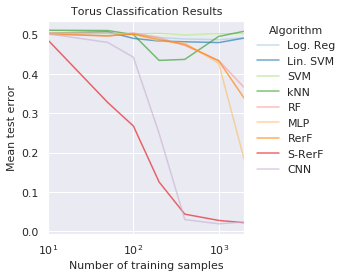

In [28]:
## Read output file log and plot
dat = pd.read_csv("s-rerf_circle_runs_all.csv")

#d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1

## CNN ADDON
dat2 = pd.read_csv("circle_cnn_results_5runs.csv")

for ni in np.unique(dat2['n']):
    for cl in np.unique(dat2['classifier']):
        if not cl in names.keys():
            continue
            
        tmp = dat2[np.logical_and(dat2['classifier'] == cl,dat2['n'] == ni)][['n', 'Lhat']]
        
        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1

fontsize = 11

sns.set(); sns.set(style="darkgrid", rc={"font.size":fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize})        
fig, ax = plt.subplots(figsize = (5,4))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

lgd = ax.legend(title='Algorithm', loc='upper left',bbox_to_anchor = (1.04,1), borderaxespad=0, frameon=False)
plt.title('Torus Classification Results')
plt.ylabel('Mean test error')
plt.xlabel('Number of training samples')
plt.tight_layout()
#plt.savefig('./s-rerf_circle_experiment.pdf',format='pdf')
plt.show()

## CNN Classification

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as utils
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [36]:
# Hyperparameters
num_epochs = 100
num_classes = 2
batch_size = 200
learning_rate = 0.001
num_cnn_runs = 5

In [37]:
tensor_x = torch.from_numpy(np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))).float()
tensor_y = torch.from_numpy(np.asarray(Y_test)).long()

test_tensor = utils.TensorDataset(tensor_x,tensor_y) # create your datset
test_loader = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=False)

In [38]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=6, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=6, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(21 * 64, 200)
        self.fc2 = nn.Linear(200, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [43]:
def cnn_learn(n, model):
    ## Data loader
    batch_size = int(n)
    
    X = X_train[0:n, ::]
    Y = Y_train[0:n]
    
    tensor_x = torch.from_numpy(np.reshape(X,(X.shape[0],1,X.shape[1]))).float()
    tensor_y = torch.from_numpy(np.asanyarray(Y)).long()

    train_tensor = utils.TensorDataset(tensor_x,tensor_y) # create your datset

    train_loader = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    trainStartTime = time.time()
    
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    prior_loss = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #images = images.float(); labels = labels.long()
            # Run the forward pass
            outputs = model(images.float())
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if ((i + 1) % 1 == 0) and ((epoch + 1) % 5 == 0):
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
        if epoch > 10:
            if loss.item() < 0.1 and stats.sem(prior_loss[-5:]) < 0.001:
                break
        prior_loss.append(loss.item())
    
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime
    
    # Test the model
    testStartTime = time.time()
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        testEndTime = time.time()
        testTime = testEndTime - testStartTime
        print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))
        
        lhat = 1- correct / total

        ####("variable,Lhat,trainTime,testTime,iterate")
        clf = "CNN"; iterate = 1
        
        return((clf,n,lhat,trainTime,testTime,iterate))

In [44]:
## Log output
np.random.seed(1234)

write_path = 'circle_cnn_results_5runs.csv'

with open(write_path, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    
runList = [(n, iterate) for n in ns\
                        for iterate in range(1, num_cnn_runs + 1)]

for n, iterate in runList:
    print(f"Size={n}, Iterate {iterate}")
    model = ConvNet()
    clf,n,lhat,trainTime,testTime,iterate = cnn_learn(n, model)
    
    with open(write_path, 'a') as f:
        f.write(f"{clf}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")

Size=10, Iterate 1
Epoch [5/100], Step [1/1], Loss: 0.5595, Accuracy: 80.00%
Epoch [10/100], Step [1/1], Loss: 0.3546, Accuracy: 90.00%
Epoch [15/100], Step [1/1], Loss: 0.1605, Accuracy: 100.00%
Epoch [20/100], Step [1/1], Loss: 0.1502, Accuracy: 100.00%
Epoch [25/100], Step [1/1], Loss: 0.0376, Accuracy: 100.00%
Epoch [30/100], Step [1/1], Loss: 0.0108, Accuracy: 100.00%
Epoch [35/100], Step [1/1], Loss: 0.0141, Accuracy: 100.00%
Epoch [40/100], Step [1/1], Loss: 0.0264, Accuracy: 100.00%
Epoch [45/100], Step [1/1], Loss: 0.0049, Accuracy: 100.00%
Epoch [50/100], Step [1/1], Loss: 0.0027, Accuracy: 100.00%
Epoch [55/100], Step [1/1], Loss: 0.0008, Accuracy: 100.00%
Epoch [60/100], Step [1/1], Loss: 0.0409, Accuracy: 100.00%
Test Accuracy of the model on the test images: 49.68 %
Size=10, Iterate 2
Epoch [5/100], Step [1/1], Loss: 0.5429, Accuracy: 90.00%
Epoch [10/100], Step [1/1], Loss: 0.3304, Accuracy: 90.00%
Epoch [15/100], Step [1/1], Loss: 0.1292, Accuracy: 100.00%
Epoch [20/100